In [36]:
import random

import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_scatter import scatter
from tqdm.auto import tqdm

In [37]:
torch.autograd.set_detect_anomaly(True)

In [38]:
from torch_geometric.datasets import Planetoid
data = Planetoid(root='data/Planetoid', name='Cora')[0]

n_nodes = data.num_nodes
n_edges = data.num_edges
n_features = data.num_features
n_targets = len(np.unique(data.y))

In [39]:
dict_vertices = {}

# Bind each vertex to a list of connected vertices
for v1, v2 in zip(*data.edge_index[:, :]):
    if str(v1.item()) not in dict_vertices:
        dict_vertices[str(v1.item())] = []
    dict_vertices[str(v1.item())] += [str(v2.item())]

In [40]:
adj_data = np.zeros((n_nodes, n_nodes))

for key, values in dict_vertices.items():
    for value in values:
        adj_data[int(key)][int(value)] = 1

adj_mat = scipy.sparse.coo_matrix(adj_data, dtype=np.float32)
deg_mat = scipy.sparse.diags(np.asarray(adj_mat.sum(axis=0))[0], shape=(n_nodes, n_nodes), dtype=np.float32)

adj_mat_tilde = adj_mat + scipy.sparse.identity(n_nodes)
deg_mat_tilde = deg_mat + scipy.sparse.identity(n_nodes)
norm_adj_mat = deg_mat_tilde.power(-0.5) @ adj_mat_tilde @ deg_mat_tilde.power(-0.5)
# Convert from DIA fromat to COO format
norm_adj_mat = norm_adj_mat.tocoo()

indices = np.vstack((norm_adj_mat.row, norm_adj_mat.col))
values = norm_adj_mat.data
norm_adj_mat = torch.sparse_coo_tensor(indices, values, dtype=torch.float)

In [51]:
norm_adj_mat = norm_adj_mat.to_dense()
norm_adj_mat.shape[0]

2708

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [30]:
class GCNLayer(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(GCNLayer, self).__init__()
        self.w = nn.Linear(n_inputs, n_outputs)
        nn.init.kaiming_uniform_(self.w.weight)
        
    def forward(self, x, norm_adj_mat):
        x = torch.spmm(norm_adj_mat, x) 
        x = self.w(x)
        
        return x
    
gcn_layer = GCNLayer(n_features, 5)
gcn_layer.to(device)

GCNLayer(
  (w): Linear(in_features=1433, out_features=5, bias=True)
)

In [31]:
import torch_geometric.nn.conv.gat_conv as gatconv
from dgl.nn.pytorch.conv import ChebConv

In [32]:
class GCN2(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs):
        super(GCN2, self).__init__()
        #self.hidden = gatconv.GATConv(n_inputs, n_hidden)
        #self.output = gatconv.GATConv(n_hidden, n_outputs)
        self.hidden = ChebConv(n_inputs, n_hidden, 5)
        self.output = ChebConv(n_hidden, n_outputs, 5)


    #def forward(self, x, norm_adj_mat):
    def forward(self, norm_adj_mat, x):
        norm_adj_mat = norm_adj_mat.to_dense()
        print(norm_adj_mat.shape)
        x = self.hidden(x, norm_adj_mat)
        x = F.relu(x)
        x = self.output(x, norm_adj_mat)
        
        return x

gcn = GCN2(n_features, 32, n_targets)
gcn.to(device)

GCN2(
  (hidden): ChebConv(
    (linear): Linear(in_features=7165, out_features=32, bias=True)
  )
  (output): ChebConv(
    (linear): Linear(in_features=160, out_features=7, bias=True)
  )
)

In [33]:
class GCN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs):
        super(GCN, self).__init__()
        self.hidden = GCNLayer(n_inputs, n_hidden)
        self.output = GCNLayer(n_hidden, n_outputs)
        
    def forward(self, x, norm_adj_mat):
        
        x = self.hidden(x, norm_adj_mat)
        x = F.relu(x)
        x = self.output(x, norm_adj_mat)
        
        return x

#gcn = GCN(n_features, 32, n_targets)
#gcn.to(device)

In [34]:
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gcn.parameters(), lr=0.01)
scaler = torch.cuda.amp.GradScaler()

c:\Users\Pablo\anaconda3\envs\py37\lib\site-packages\torch\cuda\amp\grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [35]:
training_loss = []
validation_accuracy = []

for _ in tqdm(range(epochs), leave=False):
    # Get the inputs; data is a list of [inputs, labels]
    inputs, labels = data.x, data.y[data.train_mask]

    # Zero the parameter gradients
    optimizer.zero_grad(set_to_none=True)

    # Forward + backward + optimize
    outputs = gcn(inputs, norm_adj_mat)[data.train_mask]
    with torch.cuda.amp.autocast():
        loss = criterion(outputs, labels)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    
    training_loss += [loss.item()]
    
    inputs, labels = data.x, data.y[data.val_mask]    
    # Since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        # Calculate outputs by running embeddings through the network
        outputs = gcn(inputs, norm_adj_mat)[data.val_mask]
    
    # The class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()

    accuracy = correct / total
    validation_accuracy += [accuracy]

torch.Size([2708, 1433])


AttributeError: 'Tensor' object has no attribute 'local_scope'

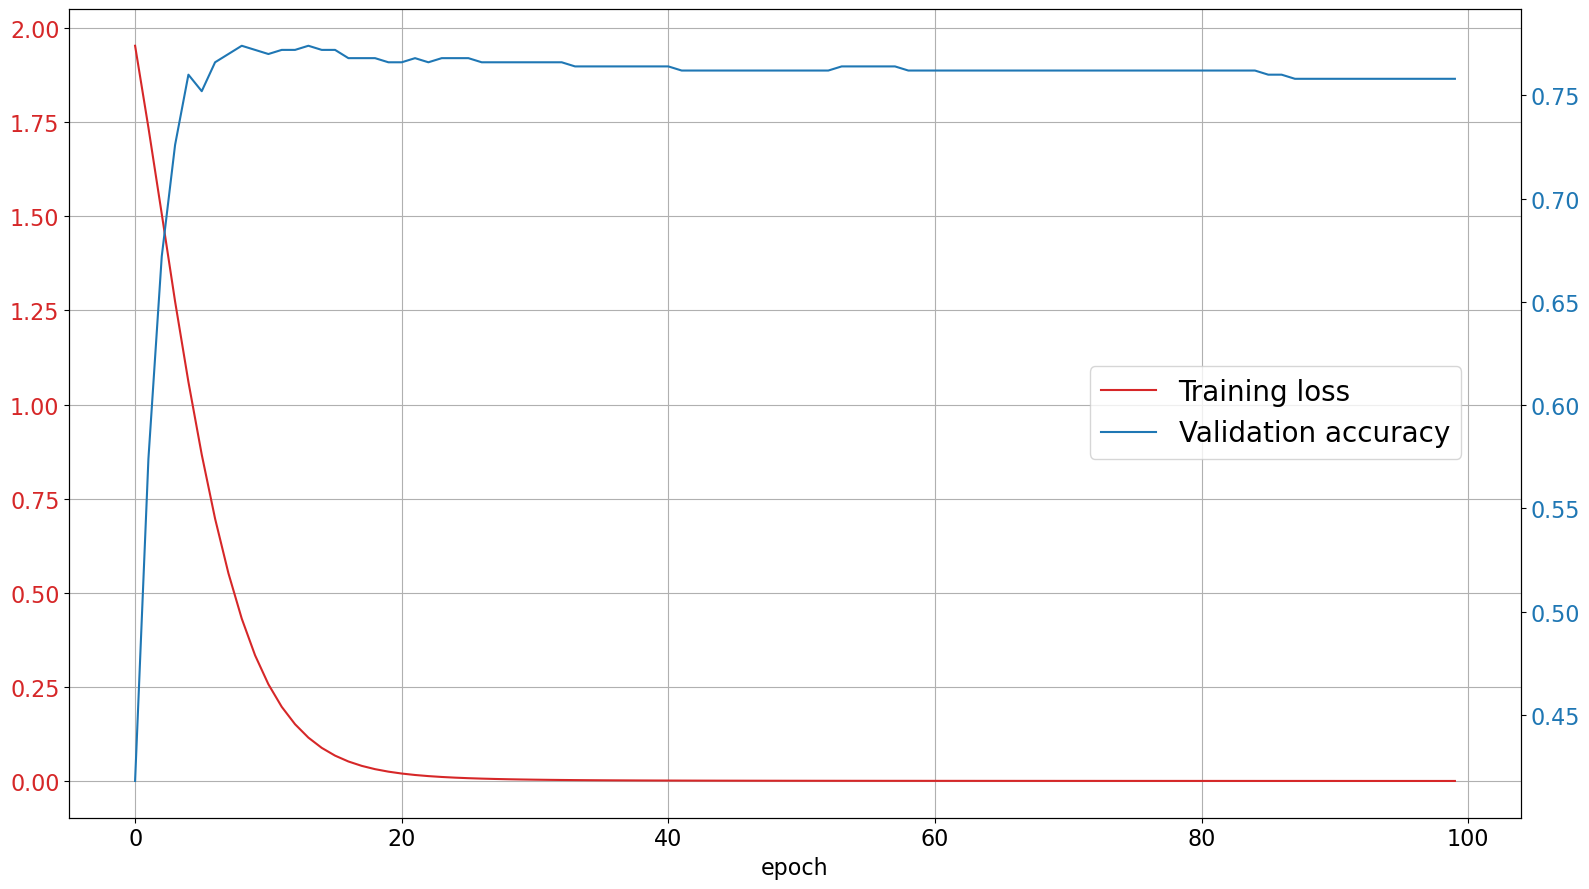

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

color = 'tab:red'
ax.plot(np.arange(epochs), training_loss, color=color, label='Training loss')
ax.tick_params(axis='y', labelcolor=color, labelsize=16)

color = 'tab:blue'
right_y = ax.twinx()
right_y.plot(np.arange(epochs), validation_accuracy, color=color, label='Validation accuracy')
right_y.tick_params(axis='y', labelcolor=color, labelsize=16)

ax.set_xlabel('epoch', fontsize=16)
ax.tick_params(axis='x', labelsize=16)

fig.tight_layout()
ax.grid(True)
fig.legend(loc='center right', fontsize=20, bbox_to_anchor=(0.925, 0.535))
plt.show()

In [ ]:
inputs, labels = data.x, data.y[data.test_mask]

# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    # Calculate outputs by running embeddings through the network
    outputs = gcn(inputs, norm_adj_mat)[data.test_mask]

# The class with the highest energy is what we choose as prediction
_, predicted = torch.max(outputs.data, 1)
total = labels.size(0)
correct = (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy in the test set: {100 * accuracy:.2f}%')

Accuracy in the test set: 78.70%
